# Theano, Lasagne
and why they matter


### got no lasagne?
Install the __bleeding edge__ version from here: http://lasagne.readthedocs.org/en/latest/user/installation.html

# Warming up
* Implement a function that computes the sum of squares of numbers from 0 to N
* Use numpy or python
* An array of numbers 0 to N - numpy.arange(N)

In [2]:
import numpy as np
np.arange(5000)

ImportError: libmkl_rt.so: cannot open shared object file: No such file or directory

In [1]:
import numpy as np
def sum_squares(N):
    nums=np.arange(N+1)

#    return [i ** 2 for i in list]

#<student.Implement_me()>
    return np.sum(np.square(range(N)))


In [6]:
%%time
#sum_squares(10**8)
sum_squares(10**5)

CPU times: user 22 ms, sys: 3 ms, total: 25 ms
Wall time: 24.6 ms


333328333350000

# theano teaser

Doing the very same thing

In [7]:
import theano
import theano.tensor as T

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5110, 5105))


In [8]:


#I gonna be function parameter
N = T.scalar("a dimension",dtype='int32')


#i am a recipe on how to produce sum of squares of arange of N given N
result = (T.arange(N)**2).sum()

#Compiling the recipe of computing "result" given N
sum_function = theano.function(inputs = [N],outputs=result)

In [12]:
%%time
sum_function(10**5)

CPU times: user 0 ns, sys: 1 ms, total: 1 ms
Wall time: 733 µs


array(333328333350000)

# How does it work?
__if you're currently in classroom, chances are i am explaining this text wall right now__
* 1 You define inputs f your future function;
* 2 You write a recipe for some transformation of inputs;
* 3 You compile it;
* You have just got a function!
* The gobbledegooky version: you define a function as symbolic computation graph.


* There are two main kinвs of entities: "Inputs" and "Transformations"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be integers, floats of booleans (uint8) of various size.


* An input is a placeholder for function parameters.
 * N from example above


* Transformations are the recipes for computing something given inputs and transformation
 * (T.arange(N)^2).sum() are 3 sequential transformations of N
 * Doubles all functions of numpy vector syntax
 * You can almost always go with replacing "np.function" with "T.function" aka "theano.tensor.function"
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * and so on.
   * builtin operations also work that way
   * np.arange(10).mean() -> T.arange(10).mean()
   * Once upon a blue moon the functions have different names or locations (e.g. T.extra_ops)
     * Ask us or google it
 
 
Still confused? We gonna fix that.

In [13]:
#Inputs
example_input_integer = T.scalar("scalar input",dtype='float32')

example_input_tensor = T.tensor4("four dimensional tensor input") #dtype = theano.config.floatX by default
#не бойся, тензор нам не пригодится



input_vector = T.vector("", dtype='int32') # vector of integers


In [25]:
#Transformations

#transofrmation: elementwise multiplication
double_the_vector = input_vector*2

#elementwise cosine
elementwise_cosine = T.cos(input_vector)

#difference between squared vector and vector itself
vector_squares = input_vector**2 - input_vector


In [26]:
#Practice time:
#create two vectors of size float32
v1= T.vector("", dtype='int32')  
v2 = T.vector("", dtype='int32') 

In [27]:
#Write a transformation(recipe):
#(vec1)*(vec2) / (sin(vec1) +1)
my_transformation = (v1*v2) / (T.sin(v1)+1)

In [28]:
print (my_transformation)
#it's okay it aint a number

Elemwise{true_div,no_inplace}.0


In [30]:
# How theano stores your transformations
theano.printing.debugprint(my_transformation)

Elemwise{true_div,no_inplace} [id A] ''   
 |Elemwise{mul,no_inplace} [id B] ''   
 | | [id C]
 | | [id D]
 |Elemwise{add,no_inplace} [id E] ''   
   |Elemwise{sin,no_inplace} [id F] ''   
   | | [id C]
   |InplaceDimShuffle{x} [id G] ''   
     |TensorConstant{1} [id H]


# Compiling
* So far we were using "symbolic" variables and transformations
 * Defining the recipe for computation, but not computing anything
* To use the recipe, one should compile it

In [31]:
#inputs = [<two vectors that my_transformation depends on>]
#outputs = [<What do we compute (can be a list of several transformation)>]
inputs=[v1,v2]
outputs=[my_transformation]

# The next lines compile a function that takes two vectors and computes your transformation
my_function = theano.function(
    inputs,outputs,
    allow_input_downcast=True #automatic type casting for input parameters (e.g. float64 -> float32)
 )

In [34]:
#using function with, lists:
print ("using python lists:")
print (my_function([1,2,3],[4,5,6]))
#print

#Or using numpy arrays:
#btw, that 'float' dtype is casted to secong parameter dtype which is float32
print ("using numpy arrays:")
print (my_function(np.arange(10),
                  np.linspace(5,6,10,dtype='float')))


using python lists:
[array([  2.1721765 ,   5.23752866,  15.77397633])]
using numpy arrays:
[array([   0.        ,    2.71522063,    5.23752866,   13.14498028,
         82.23768589,  608.63197898,   41.63286877,   21.12268139,
         20.1069868 ,   38.24041719])]


# Debugging
* Compilation can take a while for big functions
* To avoid waiting, one can evaluate transformations without compiling
* Without compilation, the code runs slower, so consider reducing input size


In [ ]:
#a dictionary of inputs
my_function_inputs = {
    my_vector:[1,2,3],
    my_vector2:[4,5,6]
}

# evaluate my_transformation
# has to match with compiled function output
print my_transformation.eval(my_function_inputs)


# can compute transformations on the fly
print "add 2 vectors", (my_vector + my_vector2).eval(my_function_inputs)

#!WARNING! if your transformation only depends on some inputs,
#do not provide the rest of them
print "vector's shape:", my_vector.shape.eval({
        my_vector:[1,2,3]
    })


* When debugging, one would generally want to reduce the computation complexity. For example, if you are about to feed neural network with 1000 samples batch, consider taking first 2.
* If you really want to debug graph of high computation complexity, you could just as well compile it (e.g. with optimizer='fast_compile')

# Do It Yourself

In [48]:
# Quest #1 - implement a function that computes a mean squared error of two input vectors
# Your function has to take 2 vectors and return a single number

#<student.define_inputs_and_transformations()>

#create two vectors of size float32
v1= T.vector("Vec1", dtype='float32')  
v2 = T.vector("Vec2", dtype='float32') 

# Numpy: mse = np.mean(np.square(v1-v2))
# Theano:
#mse = T.mean(T.square(v1-v2))
mse = T.mean((v1-v2)**2)

inputs=[v1,v2]
outputs=[mse]

# Correct below, also good
#my_vector = T.vector("vector 1",dtype='float32')
#my_vector2 = T.vector("vector 2",dtype='float32')

#mse = T.mean( (my_vector-my_vector2)**2)

#compute_mse =theano.function((my_vector,my_vector2),mse,
#allow_input_downcast=True)


compute_mse = theano.function(
    inputs,outputs,
    allow_input_downcast=True #automatic type casting for input parameters (e.g. float64 -> float32)
 )

#<student.compile_function()>

In [49]:
# Tests
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print ('Wrong result:')
                print ('mse(%s,%s)'%(el,el_2))
                print ("should be: %f, but your function returned %f"%(true_mse,my_mse))
                raise ValueError("Что-то не так")

print ("All tests passed")
            
    

All tests passed


# Shared variables

* The inputs and transformations only exist when function is called

* Shared variables always stay in memory like global variables
 * Shared variables can be included into a symbolic graph
 * They can be set and evaluated using special methods
   * but they can't change value arbitrarily during symbolic graph computation
   * we'll cover that later;
 
 
* Hint: such variables are a perfect place to store network parameters
 * e.g. weights or some metadata

In [50]:
#creating shared variable
shared_vector_1 = theano.shared(np.ones(10,dtype='float64'))

In [52]:

#evaluating shared variable (outside symbolicd graph)
print ("initial value",shared_vector_1.get_value())

# within symbolic graph you use them just as any other inout or transformation, not "get value" needed

initial value [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [56]:
#setting new value
shared_vector_1.set_value( np.arange(5) )

#getting that new value
print ("new value", shared_vector_1.get_value())

#Note that the vector changed shape
#This is entirely allowed... unless your graph is hard-wired to work with some fixed shape

new value [ 0.  1.  2.  3.  4.]


# Your turn

In [59]:
# Write a recipe (transformation) that computes an elementwise transformation of shared_vector and input_scalar
#Compile as a function of input_scalar

input_scalar = T.scalar('coefficient',dtype='float32')

#scalar_times_shared = <student.write_recipe()>
scalar_times_shared = shared_vector_1 * input_vector

shared_times_n = theano.function((input_scalar,),scalar_times_shared)
#<student.compile_function()>


UnusedInputError: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 0 is not part of the computational graph needed to compute the outputs: coefficient.
To make this error into a warning, you can pass the parameter on_unused_input='warn' to theano.function. To disable it completely, use on_unused_input='ignore'.

In [ ]:
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)",shared_times_n(5)

print "shared_times_n(-0.5)",shared_times_n(-0.5)


In [ ]:
#Changing value of vector 1 (output should change)
shared_vector_1.set_value([-1,0,1])
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)",shared_times_n(5)

print "shared_times_n(-0.5)",shared_times_n(-0.5)


# T.grad - why theano matters
* Theano can compute derivatives and gradients automatically
* Derivatives are computed symbolically, not numerically

Limitations:
* You can only compute a gradient of a __scalar__ transformation over one or several scalar or vector (or tensor) transformations or inputs.
* A transformation has to have float32 or float64 dtype throughout the whole computation graph
 * derivative over an integer has no mathematical sense


In [ ]:
my_scalar = T.scalar(name='input',dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#a derivative of v_squared by my_vector
derivative = T.grad(scalar_squared,my_scalar)

fun = theano.function([my_scalar],scalar_squared)
grad = theano.function([my_scalar],derivative) 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


x = np.linspace(-3,3)
x_squared = map(fun,x)
x_squared_der = map(grad,x)

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

# Why that rocks

In [60]:

my_vector = T.vector('float64')

#Compute the gradient of the next weird function over my_scalar and my_vector
#warning! Trying to understand the meaning of that function may result in permanent brain damage

weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) +1./T.arcsinh(my_scalar)).mean()/(my_scalar**2 +1) + 0.01*T.sin(2*my_scalar**1.5)*(T.sum(my_vector)* my_scalar**2)*T.exp((my_scalar-4)**2)/(1+T.exp((my_scalar-4)**2))*(1.-(T.exp(-(my_scalar-4)**2))/(1+T.exp(-(my_scalar-4)**2)))**2


der_by_scalar,der_by_vector = <student.compute_grad_over_scalar_and_vector()>


compute_weird_function = theano.function([my_scalar,my_vector],weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar,my_vector],der_by_scalar)


SyntaxError: invalid syntax (<ipython-input-60-2a391aa39886>, line 10)

In [ ]:
#Plotting your derivative
vector_0 = [1,2,3]

scalar_space = np.linspace(0,7)

y = [compute_weird_function(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y,label='function')
y_der_by_scalar = [compute_der_by_scalar(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y_der_by_scalar,label='derivative')
plt.grid();plt.legend()


# Almost done - Updates

* updates are a way of changing shared variables at after function call.

* technically it's a dictionary {shared_variable : a recipe for new value} which is has to be provided when function is compiled

That's how it works:

In [ ]:
# Multiply shared vector by a number and save the product back into shared vector

inputs = [input_scalar]
outputs = [scalar_times_shared] #return vector times scalar

my_updates = {
    shared_vector_1:scalar_times_shared #and write this same result bach into shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [ ]:
shared_vector_1.set_value(np.arange(5))

#initial shared_vector_1
print "initial shared value:" ,shared_vector_1.get_value()

# evaluating the function (shared_vector_1 will be changed)
print "compute_and_save(2) returns",compute_and_save(2)

#evaluate new shared_vector_1
print "new shared value:" ,shared_vector_1.get_value()



# Logistic regression example

Implement the regular logistic regression training algorithm

Tips:
* Weights fit in as a shared variable
* X and y are potential inputs
* Compile 2 functions:
 * train_function(X,y) - returns error and computes weights' new values __(through updates)__
 * predict_fun(X) - just computes probabilities ("y") given data
 
 
We shall train on a two-class MNIST dataset
* please note that target y are {0,1} and not {-1,1} as in some formulae

In [62]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X,y = mnist.data, mnist.target


print ("y [shape - %s]:"%(str(y.shape)),y[:10])

print ("X [shape - %s]:"%(str(X.shape)))
print (X[:3])
print (y[:10])

y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10. 

In [65]:
theano.config.floatX = 'float32'

In [74]:
# inputs and shareds
#shared_weights = theano.shared(np.zeros(64))
shared_weights = theano.shared(np.random.randn(64)*1e-3)
#<student.code_me()>
input_X = T.matrix("data matrix")
#<student.code_me()>
input_y = T.vector("targets vector",dtype='int32')
#<student.code_me()>

In [75]:
f=theano.function((input_X,), T.nnet.sigmoid(input_X.dot(shared_weights)),allow_input_downcast=True)
f(X[:10])

array([ 0.49338426,  0.48627991,  0.48971972,  0.49017244,  0.49999506,
        0.49399609,  0.49255019,  0.49410707,  0.49386729,  0.4926409 ])

In [78]:
predicted_y = T.nnet.sigmoid(input_X.dot(shared_weights))
#<predicted probabilities for input_X>
loss = -T.mean(input_y*T.log(predicted_y) + (1-input_y)*T.log(1-predicted_y))
#<logistic loss (scalar, mean over sample)>

grad = T.grad(loss,shared_weights)
#<gradient of loss over model weights>



updates = {
    shared_weights: shared_weights - 0.01*grad}

In [95]:
train_function = theano.function([input_X,input_y],loss,updates=updates,allow_input_downcast=True)
#<compile function that takes X and y, returns log loss and updates weights>
predict_function = theano.function((input_X,),predicted_y,allow_input_downcast=True)
#<compile function that takes X and computes probabilities of y>

In [96]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

loss at iter 0:0.0386
train auc: 1.0
test auc: 1.0
loss at iter 1:0.0358
train auc: 1.0
test auc: 1.0
loss at iter 2:0.0335
train auc: 1.0
test auc: 1.0
loss at iter 3:0.0315
train auc: 1.0
test auc: 1.0
loss at iter 4:0.0297
train auc: 1.0
test auc: 1.0
resulting weights:


/appl/opt/python/3.4.5-gcc493-shared/lib/python3.4/site-packages/matplotlib-1.4.3-py3.4-linux-x86_64.egg/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


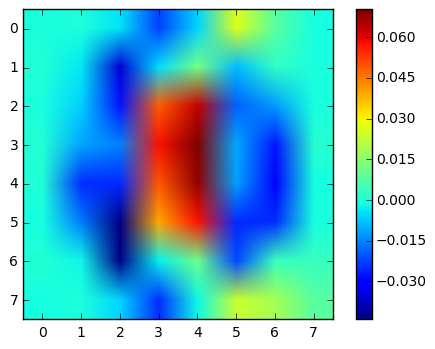

In [98]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(5):
    loss_i = train_function(X_train,y_train)
    print ("loss at iter %i:%.4f"%(i,loss_i))
    print ("train auc:",roc_auc_score(y_train,predict_function(X_train)))
    print ("test auc:",roc_auc_score(y_test,predict_function(X_test)))

    
print ("resulting weights:")
plt.imshow(shared_weights.get_value().reshape(8,-1))
plt.colorbar()

# my1stNN
Your ultimate task for this week is to build your first neural network [almost] from scratch and pure theano.

This time you will same digit recognition problem, but at a larger scale
* images are now 28x28
* 10 different digits
* 50k samples

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) NN should already have ive you an edge over logistic regression.

__[kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! The milestones would be 95%/97.5%/98.5% accuraсy on test set.

__SPOILER!__
At the end of the notebook you will find a few tips and frequently made mistakes. If you feel enough might to shoot yourself in the foot without external assistance, we encourage you to do so, but if you encounter any unsurpassable issues, please do look there before mailing us.


In [7]:
from mnist import load_dataset

#[down]loading the original MNIST dataset.
#Please note that you should only train your NN on _train sample,
# _val can be used to evaluate out-of-sample error, compare models or perform early-stopping
# _test should be hidden under a rock untill final evaluation... But we both know it is near impossible to catch you evaluating on it.
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print (X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


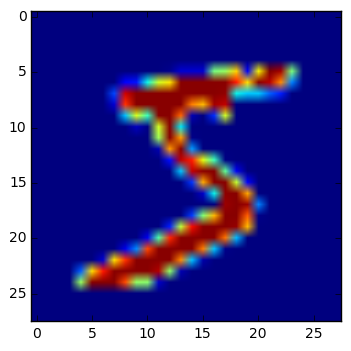

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X_train[0,0])

In [ ]:
<here you could just as well create computation graph>

In [ ]:
<this may or may not be a good place to evaluating loss and updates>

In [ ]:
<here one could compile all the required functions>

In [ ]:
<this may be a perfect cell to write a training&evaluation loop in>

In [ ]:
<predict & evaluate on test here, right? No cheating pls.>

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Recommended pipeline

* Adapt logistic regression from previous assignment to classify some number against others (e.g. zero vs nonzero)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as T.nnet.softmax (stable)
  - probably better to use STOCHASTIC gradient descent (minibatch)
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - Do not initialize layers with zeros (due to symmetry effects). A gaussian noize with small sigma will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal casae this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.
  